<a href="https://colab.research.google.com/github/sizhky/AutoTrain/blob/segmentation/nbs/segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup Data and Libraries

In [1]:
%%capture
# Setup imports
try:
    from icevision.all import *
except:
    !pip install -U torch-snippets typer imgaug
    !wget https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
    !bash install_colab.sh

In [2]:
# Setup Data
%load_ext autoreload
%autoreload 2

from torch_snippets import *

# If running locally from AutoTrain/nbs
if not os.path.exists('/content') and P().resolve().stem != 'AutoTrain':
    %cd ..

# If running from colab
if os.path.exists('/content') and not os.path.exists('/content/AutoTrain'):
    !git clone https://github.com/sizhky/AutoTrain

# change present working directory
if not P().resolve().stem == 'AutoTrain':
    %cd AutoTrain


/mnt/sda1/code/AutoTrain


## Verify Config

In [3]:
!cat configs/segmentation.ini

[project]
owner: sizhky
name: balloon
location: ${project.name}
model_directory: ${project.location}/models
num_classes: 1
classes: ["Balloon"]
type: segmentation
data_source_url: https://yyr-sample-datasets.s3.us-east-2.amazonaws.com/balloon.tar.xz

[architecture]
model_type: torchvision.mask_rcnn
backbone: resnet34_fpn
pretrained: True
size: 384
[architecture.extra_args]

[training]
; absolute path, or path relative to AutoTrain folder
dir: /home/yyr/data/balloon/
; folder should be exported from label studio, 
; in COCO format for segmentation, i.e., 
; it should have one images dir and one results.json file
images_dir: ${training.dir}/images
annotations_file: ${training.dir}/result.json
train_ratio: 0.8

[training.preprocess]
@augmentations: my_train_transforms
size: ${architecture.size}
presize: 512

[training.scheme]
epochs: 25
freeze_epochs: 5
resume_training_from: ${project.model_directory}/model.pt
output_path: ${project.model_directory}/model.pt

[testing]
[testing.preprocess

In [ ]:
!python main.py train --task segmentation --config configs/segmentation.ini

INFO     - 
CLASSES INFERRED FROM /home/yyr/data/balloon//result.json: <ClassMap: {'background': 0, 'balloon': 1}> | auto_train.segmentation.model:create_parser:50
100%|███████████████████████████████████████| 255/255 [00:00<00:00, 3909.11it/s]
INFO     - Autofixing records | icevision.parsers.parser:parse:122
100%|█████████████████████████████████████████| 61/61 [00:00<00:00, 4915.99it/s]
INFO     - Training from scratch! | auto_train.segmentation.train:train_model:24
/home/yyr/miniconda3/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
INFO     - LR Plot is saved at balloon/find_lr_plot.png | auto_train.common.utils:find_best_learning_rate:19
INF

---
## Validate

  0%|          | 0/1 [00:00<?, ?it/s]

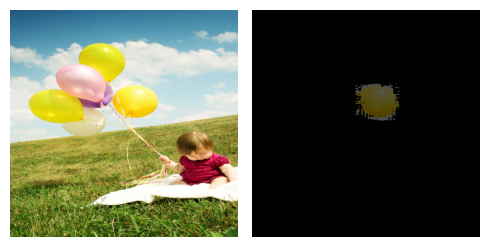

In [74]:
from auto_train.segmentation.infer import infer
fpath = P('/home/yyr/data/balloon/validation/').sample() # 16335852991_f55de7958d_k.jpg'
x = infer(fpath)

mask = x[0].pred.detection.mask_array.to_tensor().sum(0) / 3
mask = mask[...,None].repeat(1, 1, 3)
im = torch.Tensor(resize(read(fpath, 1).copy(), (384,384)))
subplots([im, (im * mask).int()])

In [76]:
x[0].pred.detection.mask_array.to_tensor().shape

torch.Size([1, 384, 384])